# Рекурентные сети для обработки последовательностей

Выяснить какая архитектура больше подходит для задачи сентимент анализа на данных с вебинара
 
1. построить свёрточную архитектуру
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN и/или (RNN -> CNN)
4. сделать выводы что получилось лучше


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm 
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from razdel import tokenize
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

%matplotlib inline


In [ ]:
RANDOM_STATE = 42

#Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/8 урок/data/'

df_train = pd.read_csv(PATH + "train.csv", index_col='id')
# df_test = pd.read_csv(PATH + "test.csv", index_col='id')
df_val = pd.read_csv(PATH + "val.csv", index_col='id')

In [ ]:
df_train.head(5)

,text,class
id,,
0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [ ]:
df_val.head(5)

,text,class
id,,
181467,RT @TukvaSociopat: Максимальный репост! ))) #є...,1
181468,чтоб у меня з.п. ежегодно индексировали на инд...,0
181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
181470,"@inafish нее , когда ногами ахахах когда?ахаха...",0
181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


In [ ]:
df_train.shape, df_val.shape

((181467, 2), (22683, 2))

Распределение классов

In [ ]:
df_train['class'].value_counts()

1    92063
0    89404
Name: class, dtype: int64

Дисбаланса нет, можно использовать метрику accuracy

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181467 entries, 0 to 181466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    181467 non-null  object
 1   class   181467 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ MB


#Предобработка текста

In [ ]:
sw = set(get_stop_words('ru'))
lemmatize = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess_txt(text):

  # Убираем характерные для твиттера обращения с никами пользователей,  
  # не хотим, чтобы модели переобучались на чьи-то ники
  text = re.sub('@\w+', '', text)

  # Убираем символы переноса строки
  text = re.sub(r'\n', '', text)

  # Убираем символы ретвита
  text = re.sub(r'rt', '', text)

  # Чистим пунктуацию
  text = re.sub(fr'[{punctuation}]+', ' ', text)

  # Убираем всё, не являющееся набором букв, + цифры
  text = ' '.join(word for word in text.split() if word.isalpha())
  # Приводим к общему регистру
  text = text.lower().split()

  # лемматизация + удаляем слова из стоп-листа
  text = [lemmatize.lemmatize(word) for word in text if word not in sw]

  # Возвращаем обработанный текст
  return ' '.join(text)

In [ ]:
with Pool(12) as p:
    df_train['processed'] = tqdm(p.imap(preprocess_txt, df_train['text']), total=len(df_train))
    df_val['processed'] = tqdm(p.imap(preprocess_txt, df_val['text']), total=len(df_val))

100%|██████████| 22683/22683 [00:02<00:00, 7778.01it/s]


In [ ]:
df_train['processed'].sample(10)

id
107107                                 rt ленте своим аском
72496     какое европейское светлое завтра украины скоро...
177677                        ой чтоооо вообще пересмотрела
44355     rt счастливым пей крайзи колу ночью бегай туал...
45586     ищете процессе поиска куча никчёмных лентяев к...
149065    осознала достаточно самодостаточна обожаю своб...
11034     соседи сверху играют главную тему реквиема меч...
137910                                                повод
60405     внезапно planet war стартовал требует moonligh...
142607    team viewer иной незаменимая программа портабе...
Name: processed, dtype: object

Для выбора длины последовательностей оценим распределение длин по датасету

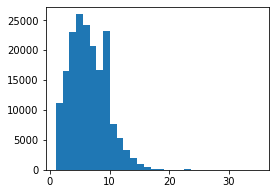

In [ ]:
plt.figure(figsize=(4, 3))
plt.hist(df_train['processed'].apply(lambda x: len(x.split(' '))), bins=30);

In [ ]:
MAX_WORDS = 2000
MAX_LEN = 20

Создадаю словарь:

In [ ]:
# корпус текста
corpus = ' '.join(df_train['processed']).lower()
corpus


In [ ]:
# генерация токенов
tokens = word_tokenize(corpus)
tokens[:5]

['уезжаааааааай', 'хочу', 'уезжала', 'rt', 'ребята']

In [ ]:
dist = FreqDist(tokens)
tokens_top = [pair[0] for pair in dist.most_common(MAX_WORDS-1)]  # вычитание 1 для padding
len(tokens_top), tokens_top[:10]

(1999,
 ['rt', 'http', 't', 'co', 'd', 'хочу', 'завтра', 'вообще', 'могу', 'блин'])

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_top, 1)).items()}
# vocabulary

In [ ]:
len(vocabulary)

1999

In [ ]:
VOCAB_SIZE = len(vocabulary) + 1

In [ ]:
# преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text)
    # tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens:
        if word in vocabulary:
            result.append(vocabulary[word]) # если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) # нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [ ]:
%%time
x_train = np.asarray([text_to_sequence(text, MAX_LEN) for text in df_train['processed']])
x_valid = np.asarray([text_to_sequence(text, MAX_LEN) for text in df_val['processed']])
x_train.shape

CPU times: user 17 s, sys: 0 ns, total: 17 s
Wall time: 17 s


(181467, 20)

In [ ]:
print(f"Оригинальная строка: {df_train['processed'].iloc[8]}")
print(f"Обработанная строка: {x_train[8]}")

Оригинальная строка: неудачик поцарапал экран телефоне
Обработанная строка: [704   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
# Training
batch_size = 256

In [ ]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() # преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() # преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index] # индексация данных
        y = self.target[index] # индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
torch.random.manual_seed(RANDOM_STATE)

train_dataset = DataWrapper(x_train, df_train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = DataWrapper(x_valid, df_val['class'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#Построение моделей

CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, embed_dim=128, conv_filters=128, kernel_size=3, conv_stride=1):
        torch.random.manual_seed(RANDOM_STATE)
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=0)
        
        self.conv = nn.Sequential(nn.Conv1d(embed_dim, conv_filters, kernel_size=kernel_size, stride=conv_stride),
                                  nn.MaxPool1d(MAX_LEN // conv_stride - kernel_size + 1),
                                  nn.ReLU())
        
        self.fc1 = nn.Sequential(nn.Linear(conv_filters, conv_filters // 2),
                                 nn.ReLU())
        
        self.dp02 = nn.Dropout(0.2)
        self.dp05 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(conv_filters // 2, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dp02(x)
        x = x.permute(0, 2 ,1)
        x = torch.squeeze(self.conv(x))
        x = self.fc1(x)
        x = self.dp05(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
summary(ConvNet())

Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Embedding: 1-1                         256,000
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       49,280
│    └─MaxPool1d: 2-2                    --
│    └─ReLU: 2-3                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-4                       8,256
│    └─ReLU: 2-5                         --
├─Dropout: 1-4                           --
├─Dropout: 1-5                           --
├─Linear: 1-6                            65
Total params: 313,601
Trainable params: 313,601
Non-trainable params: 0

In [ ]:
# Функция для обучения сетей
def train_nn(net, epochs=5, lr=1e-3):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True

    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        train_losses = np.array([])
        test_losses = np.array([])
        train_metrics = np.array([])
        test_metrics = np.array([])

        for i, (inputs, labels) in enumerate(train_loader):
            net.train()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()

            train_losses = np.append(train_losses, loss.item())

            net.eval()
            outputs = net(inputs)
            train_metrics = np.append(train_metrics, accuracy_score(labels.cpu(), torch.squeeze(outputs > 0.5).cpu()))

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Train Loss: {train_losses.mean():.3f}. ' \
              f'Train Accuracy: {train_metrics.mean():.3f}', end='. ')


        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                loss = criterion(outputs, labels.float().view(-1, 1))
                test_losses = np.append(test_losses, loss.item())
                test_metrics = np.append(test_metrics, accuracy_score(labels.cpu(), torch.squeeze(outputs > 0.5).cpu()))
                
        print(f'Test loss: {test_losses.mean():.3f}. Test Accuracy: {test_metrics.mean():.3f}')

    print('Training is finished!')

In [ ]:
conv_model = ConvNet(embed_dim=128, conv_filters=128, kernel_size=5, conv_stride=1)
CNN = train_nn(conv_model, epochs=40, lr=1e-3)

Epoch [1/40]. Train Loss: 0.594. Train Accuracy: 0.671. Test loss: 0.560. Test Accuracy: 0.687
Epoch [2/40]. Train Loss: 0.550. Train Accuracy: 0.714. Test loss: 0.544. Test Accuracy: 0.703
Epoch [3/40]. Train Loss: 0.535. Train Accuracy: 0.727. Test loss: 0.541. Test Accuracy: 0.705
Epoch [4/40]. Train Loss: 0.522. Train Accuracy: 0.737. Test loss: 0.543. Test Accuracy: 0.704
Epoch [5/40]. Train Loss: 0.512. Train Accuracy: 0.745. Test loss: 0.545. Test Accuracy: 0.704
Epoch [6/40]. Train Loss: 0.502. Train Accuracy: 0.754. Test loss: 0.545. Test Accuracy: 0.705
Epoch [7/40]. Train Loss: 0.494. Train Accuracy: 0.761. Test loss: 0.547. Test Accuracy: 0.702
Epoch [8/40]. Train Loss: 0.485. Train Accuracy: 0.767. Test loss: 0.552. Test Accuracy: 0.704
Epoch [9/40]. Train Loss: 0.476. Train Accuracy: 0.774. Test loss: 0.556. Test Accuracy: 0.704
Epoch [10/40]. Train Loss: 0.469. Train Accuracy: 0.779. Test loss: 0.564. Test Accuracy: 0.702
Epoch [11/40]. Train Loss: 0.462. Train Accuracy:

Свёрточная модель показала точность чуть ниже 70%.

RNN

In [ ]:
class GRUFixedLen(nn.Module) :
    def __init__(self, embed_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=0)
        self.gru = nn.GRU( embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [ ]:
summary(GRUFixedLen())

Layer (type:depth-idx)                   Param #
GRUFixedLen                              --
├─Embedding: 1-1                         256,000
├─GRU: 1-2                               198,144
├─Linear: 1-3                            129
├─Dropout: 1-4                           --
Total params: 454,273
Trainable params: 454,273
Non-trainable params: 0

In [ ]:
rnn_model = GRUFixedLen(embed_dim=128, hidden_dim=128, use_last=True)
rnn = train_nn(rnn_model, epochs=40, lr=5e-4)

Epoch [1/40]. Train Loss: 0.593. Train Accuracy: 0.665. Test loss: 0.556. Test Accuracy: 0.692
Epoch [2/40]. Train Loss: 0.550. Train Accuracy: 0.710. Test loss: 0.546. Test Accuracy: 0.702
Epoch [3/40]. Train Loss: 0.541. Train Accuracy: 0.717. Test loss: 0.543. Test Accuracy: 0.704
Epoch [4/40]. Train Loss: 0.535. Train Accuracy: 0.719. Test loss: 0.540. Test Accuracy: 0.704
Epoch [5/40]. Train Loss: 0.530. Train Accuracy: 0.723. Test loss: 0.543. Test Accuracy: 0.705
Epoch [6/40]. Train Loss: 0.526. Train Accuracy: 0.726. Test loss: 0.538. Test Accuracy: 0.706
Epoch [7/40]. Train Loss: 0.522. Train Accuracy: 0.728. Test loss: 0.537. Test Accuracy: 0.708
Epoch [8/40]. Train Loss: 0.518. Train Accuracy: 0.731. Test loss: 0.538. Test Accuracy: 0.706
Epoch [9/40]. Train Loss: 0.515. Train Accuracy: 0.735. Test loss: 0.538. Test Accuracy: 0.710
Epoch [10/40]. Train Loss: 0.510. Train Accuracy: 0.738. Test loss: 0.537. Test Accuracy: 0.707
Epoch [11/40]. Train Loss: 0.506. Train Accuracy:

У рекуррентной модели точность уже повыше, чуть больше 70%

RNN + CNN

Выходы рекуррентной сети будут эмбеддингами свёрточной
сети. Поэтому из рекуррентной сети берём не только вектор последнего
скрытого состояния, а все вектора скрытого состояния, на каждом временном
отрезке t

In [ ]:
class RnnConvNet(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=128, conv_filters=128, kernel_size=3, conv_stride=1):
        torch.random.manual_seed(RANDOM_STATE)
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=0)
        
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        
        self.conv = nn.Sequential(nn.Conv1d(hidden_dim, conv_filters, kernel_size=kernel_size, stride=conv_stride),
                                  nn.MaxPool1d(MAX_LEN // conv_stride - kernel_size + 1),
                                  nn.ReLU())
        
        self.fc1 = nn.Sequential(nn.Linear(conv_filters, conv_filters // 2),
                                 nn.ReLU())
        
        self.dp02 = nn.Dropout(0.2)
        self.dp05 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(conv_filters // 2, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dp02(x)
        
        # Берём все векторы h
        x, _ = self.gru(x)
        
        x = x.permute(0, 2 ,1)
        x = torch.squeeze(self.conv(x))
        x = self.fc1(x)
        x = self.dp05(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
summary(RnnConvNet())

Layer (type:depth-idx)                   Param #
RnnConvNet                               --
├─Embedding: 1-1                         256,000
├─GRU: 1-2                               99,072
├─Sequential: 1-3                        --
│    └─Conv1d: 2-1                       49,280
│    └─MaxPool1d: 2-2                    --
│    └─ReLU: 2-3                         --
├─Sequential: 1-4                        --
│    └─Linear: 2-4                       8,256
│    └─ReLU: 2-5                         --
├─Dropout: 1-5                           --
├─Dropout: 1-6                           --
├─Linear: 1-7                            65
Total params: 412,673
Trainable params: 412,673
Non-trainable params: 0

In [ ]:
rnn_conv_model = RnnConvNet(kernel_size=5)
rnn_cnn = train_nn(rnn_conv_model, epochs=15, lr=5e-4)

Epoch [1/15]. Train Loss: 0.593. Train Accuracy: 0.669. Test loss: 0.557. Test Accuracy: 0.690
Epoch [2/15]. Train Loss: 0.553. Train Accuracy: 0.708. Test loss: 0.546. Test Accuracy: 0.704
Epoch [3/15]. Train Loss: 0.542. Train Accuracy: 0.718. Test loss: 0.541. Test Accuracy: 0.706
Epoch [4/15]. Train Loss: 0.534. Train Accuracy: 0.724. Test loss: 0.541. Test Accuracy: 0.706
Epoch [5/15]. Train Loss: 0.527. Train Accuracy: 0.729. Test loss: 0.542. Test Accuracy: 0.708
Epoch [6/15]. Train Loss: 0.520. Train Accuracy: 0.736. Test loss: 0.539. Test Accuracy: 0.707
Epoch [7/15]. Train Loss: 0.513. Train Accuracy: 0.742. Test loss: 0.541. Test Accuracy: 0.706
Epoch [8/15]. Train Loss: 0.506. Train Accuracy: 0.750. Test loss: 0.544. Test Accuracy: 0.707
Epoch [9/15]. Train Loss: 0.498. Train Accuracy: 0.757. Test loss: 0.545. Test Accuracy: 0.707
Epoch [10/15]. Train Loss: 0.490. Train Accuracy: 0.764. Test loss: 0.546. Test Accuracy: 0.710
Epoch [11/15]. Train Loss: 0.482. Train Accuracy:

Такой же результат как и у рекуррентной модели

CNN + RNN

Тут, в отличие от CNN сети, просто добавлю
пулинг после свёртки, так как нужно всё получившееся пространство,
которое будет эмбеддингом для рекуррентной сети:


In [ ]:
class ConvRnnNet(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=128, conv_filters=128, kernel_size=3, conv_stride=1):
        torch.random.manual_seed(RANDOM_STATE)
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=0)
        
        self.conv = nn.Sequential(nn.Conv1d(embed_dim, conv_filters, kernel_size=kernel_size, stride=conv_stride),
                                  nn.ReLU())
        
        self.gru = nn.GRU(conv_filters, hidden_dim, batch_first=True)
        
        self.fc1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),
                                 nn.ReLU())
        
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.dp02 = nn.Dropout(0.2)
        self.dp05 = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.dp02(x)
        x = x.permute(0, 2 ,1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        _, x = self.gru(x)
        x = self.fc1(torch.squeeze(x))
        x = self.dp05(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
summary(ConvRnnNet())

Layer (type:depth-idx)                   Param #
ConvRnnNet                               --
├─Embedding: 1-1                         256,000
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       49,280
│    └─ReLU: 2-2                         --
├─GRU: 1-3                               99,072
├─Sequential: 1-4                        --
│    └─Linear: 2-3                       8,256
│    └─ReLU: 2-4                         --
├─Linear: 1-5                            65
├─Dropout: 1-6                           --
├─Dropout: 1-7                           --
Total params: 412,673
Trainable params: 412,673
Non-trainable params: 0

In [ ]:
conv_rnn_model = ConvRnnNet(kernel_size=5)
cnn_rnn = train_nn(conv_rnn_model, epochs=30, lr=5e-4)

Epoch [1/30]. Train Loss: 0.609. Train Accuracy: 0.648. Test loss: 0.567. Test Accuracy: 0.682
Epoch [2/30]. Train Loss: 0.561. Train Accuracy: 0.704. Test loss: 0.551. Test Accuracy: 0.697
Epoch [3/30]. Train Loss: 0.542. Train Accuracy: 0.721. Test loss: 0.545. Test Accuracy: 0.701
Epoch [4/30]. Train Loss: 0.529. Train Accuracy: 0.732. Test loss: 0.545. Test Accuracy: 0.702
Epoch [5/30]. Train Loss: 0.518. Train Accuracy: 0.740. Test loss: 0.549. Test Accuracy: 0.703
Epoch [6/30]. Train Loss: 0.509. Train Accuracy: 0.748. Test loss: 0.548. Test Accuracy: 0.703
Epoch [7/30]. Train Loss: 0.502. Train Accuracy: 0.755. Test loss: 0.550. Test Accuracy: 0.702
Epoch [8/30]. Train Loss: 0.493. Train Accuracy: 0.762. Test loss: 0.556. Test Accuracy: 0.702
Epoch [9/30]. Train Loss: 0.484. Train Accuracy: 0.768. Test loss: 0.554. Test Accuracy: 0.705
Epoch [10/30]. Train Loss: 0.477. Train Accuracy: 0.773. Test loss: 0.557. Test Accuracy: 0.701
Epoch [11/30]. Train Loss: 0.470. Train Accuracy:

Тут вообще результат хуже остальных моделей. Думаю для улучшения работы моделей нужно детальнее сделать предобработку, подобрать оптимальные параметры у моделей коэффициент обучения, количество эпох, поиграться с архитекрутой сети. Можно так же попробовать сделать токенизацию по символам.

На данном этапе лучшей моделью оказалась комбинация RNN + CNN